In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import itertools

from config import Config

In [2]:
config = Config()
df_path = f"{config.EXP_PATH}/results.csv"
df = pd.read_csv(df_path)

df['name']  = df['src'].str.lower() + "_" + df['tgt'].str.lower()
df['is_id'] = (df['src'] + "1" == df['tgt'])

df.head()

,corpus_length,src,tgt,bleu,chrF2,num_steps,name,is_id
0,1000,SVO,SOV,11.6,47.0,2012,svo_sov,False
1,1000,SVO,VSO,16.9,50.9,1743,svo_vso,False
2,1000,SVO,VOS,14.9,53.0,2448,svo_vos,False
3,1000,SVO,OSV,11.6,48.3,2836,svo_osv,False
4,1000,SVO,OVS,16.2,48.6,2334,svo_ovs,False


In [3]:
name_df = df.groupby('name').apply(lambda x : x)
name_df

corpus_length  src   tgt  bleu  chrF2  num_steps      name  \
name                                                                       
osv_osv1 19            1000  OSV  OSV1  11.7   48.4       1764  osv_osv1   
         40            2000  OSV  OSV1  25.2   59.3       3702  osv_osv1   
         61            4000  OSV  OSV1  31.2   61.3       5368  osv_osv1   
         82            8000  OSV  OSV1  37.1   66.0       8925  osv_osv1   
         103          16000  OSV  OSV1  42.3   69.7      18564  osv_osv1   
...                     ...  ...   ...   ...    ...        ...       ...   
vso_vso1 17            1000  VSO  VSO1  14.2   54.1       1773  vso_vso1   
         38            2000  VSO  VSO1  31.0   63.2       3480  vso_vso1   
         59            4000  VSO  VSO1  36.0   63.9       6127  vso_vso1   
         80            8000  VSO  VSO1  43.2   69.1       9100  vso_vso1   
         101          16000  VSO  VSO1  47.3   72.0      16341  vso_vso1   

              is_id  
name                 
osv_osv1 19    True  
         40    True  
         61    True  
         82    True  
         103   True  
...             ...  
vso_vso1 17    True  
         38    True  
         59    True  
         80    True  
         101   True  

[107 rows x 8 columns]

In [27]:
def plot_scores_vs_steps_V2(df=df, score='bleu', selected_names=None):
    # Ensure that the score and size columns exist
    if score not in df.columns:
        raise ValueError(f"Score '{score}' not found in DataFrame columns.")
    if 'corpus_length' not in df.columns:
        raise ValueError("Column 'corpus_length' not found in DataFrame columns.")

    plt.figure(figsize=(12,8))

    # Create a color mapping based on unique 'size' values
    unique_sizes = df['corpus_length'].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_sizes)))
    size_color_map = dict(zip(unique_sizes, colors))

    # Prepare legend handles
    legend_handles = []

    for size in unique_sizes:
        # Create a scatter plot for each size for legend purpose (without actual data)
        scatter = plt.scatter([], [], color=size_color_map[size], label=f"Size {size}")
        legend_handles.append(scatter)

    for name, group in df.groupby('name'):
        # Filter based on selected names, if provided
        if selected_names is not None and name not in selected_names:
            continue

        for size in unique_sizes:
            # Filter the group for each size
            size_group = group[group['corpus_length'] == size]

            # Scatter plot for num_steps vs score, with color based on size
            plt.scatter(size_group['num_steps'], size_group[score], color=size_color_map[size])

            # Annotating each point with its name and corpus_length
            for _, row in size_group.iterrows():
                plt.annotate(f"{name}", (row['num_steps'], row[score]), fontsize=6)  # Smaller font size

    # Set labels and title
    score_label = "BLEU" if score == 'bleu' else 'chrF2'
    plt.title(f'{score_label} Scores vs. Number of Steps')
    plt.xlabel("Number of Steps")
    plt.ylabel(f"{score_label} Score")

    # Show legend and grid
    plt.legend(handles=legend_handles)
    plt.grid(True)
    plt.show()


In [28]:
def plot_select_scores(df, score='bleu', selected_names=None):
    # group by name then find all corp_len, score pairs
    grouped = df.groupby('name').apply(lambda x: list(zip(x['corpus_length'], x[score])))
    data = grouped.to_dict()

    plt.figure(figsize=(10,6))

    # Colors and markers setup
    colors = ['#00BFFF', '#228B22', '#FF6347', '#7851A9', '#FFA500', '#008080', '#708090']
    color_cycle = itertools.cycle(colors)
    markers = ['o', 's', '^', 'x', '*', '+', 'd']
    marker_cycle = itertools.cycle(markers)

    # Find common corpus length C
    common_lengths = set.intersection(*(set(map(lambda x: x[0], v)) for v in data.values()))
    C = max(common_lengths)

    # Calculate scores at C and filter models
    scores_at_C = {name: next(score for length, score in points if length == C) for name, points in data.items()}

    handles = []

    for name, points in data.items():
        if selected_names is not None and name not in selected_names:
            continue

        lengths, scores = zip(*points)
        color = next(color_cycle)
        marker = next(marker_cycle)
        line, = plt.plot(lengths, scores, label=f"{name}: {scores_at_C.get(name, 0)}", color=color, marker=marker, linestyle='-')
        handles.append(line)

    # Sorting the legend based on score at C
    sorted_handles = sorted(zip(scores_at_C.values(), handles), key=lambda x: x[0], reverse=True)
    handles = [handle for _, handle in sorted_handles]

    # Placing legend outside the plot
    plt.legend(handles, [h.get_label() for h in handles], loc='center left', bbox_to_anchor=(1, 0.5))

    # Plot titles and labels
    name = "BLEU" if score == 'bleu' else 'chrF2'
    plt.title(f'{name} Scores vs. Corpus Lengths')
    plt.xlabel("Corpus Size")
    plt.ylabel(f"{name} Score")

    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()


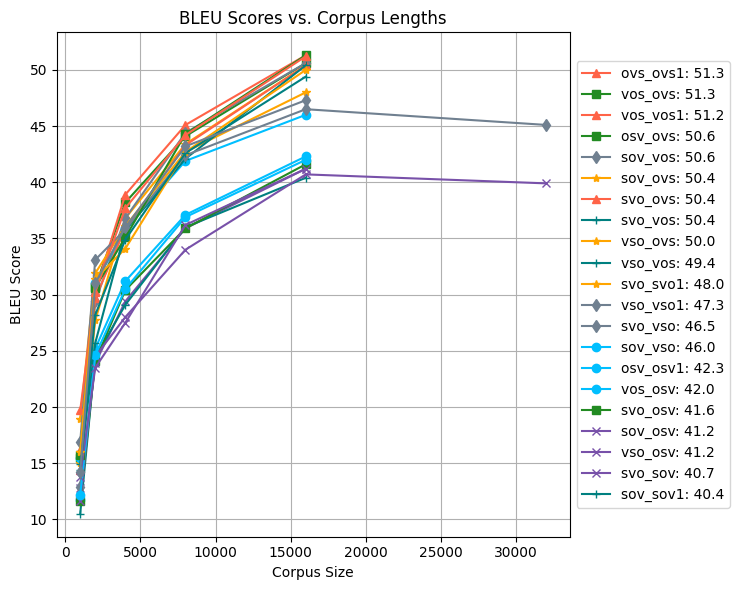

In [29]:
plot_select_scores(df)

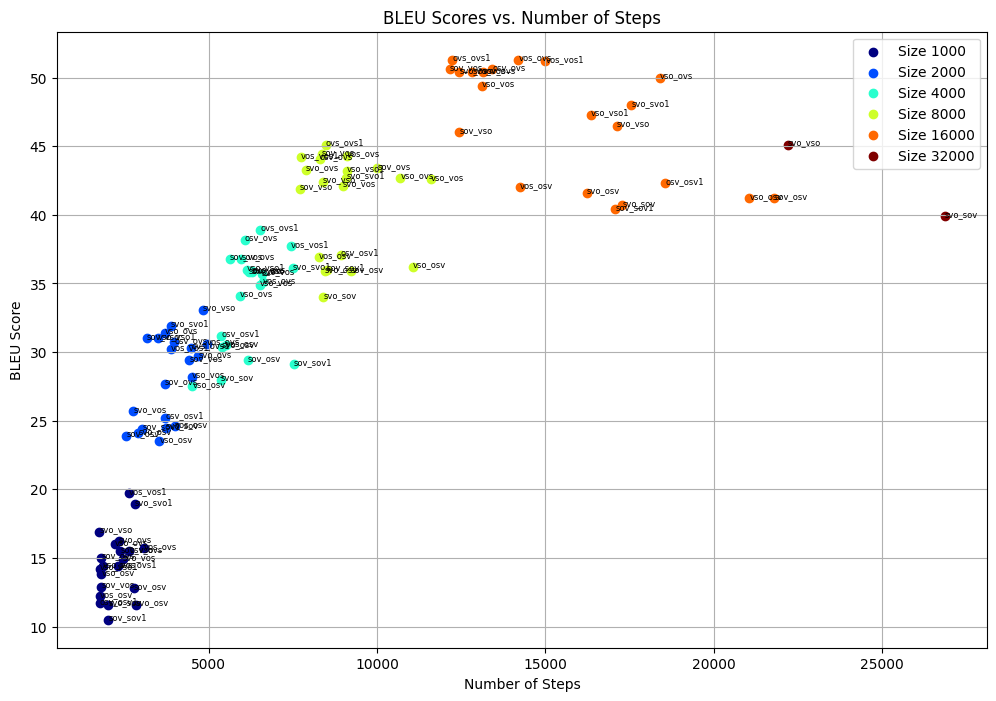

In [30]:
plot_scores_vs_steps_V2()